<a href="https://colab.research.google.com/github/otakmager/KTP-CS344-CUDA/blob/master/ProblemSet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 👷‍♂️ Anggota Kelompok:
1. Dimas Wahyu Ardiyanto - 24060120140159
2. Muhammad Hafizh Roihan - 24060120130123

## 📑 Menyiapkan Environment & Instalasi CUDA

In [28]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2022-11-18 13:07:54--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/downloads/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2022-11-18 13:07:54--  https://developer.nvidia.com/downloads/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?9K4Bwd1k0q9MlTSnb8rNKJYGrQCznZBE86k_RMg1-a3ruRsgBdMsHovJaDXXPuD0U4zf9ORy-Ko26GEJGJCWU-0Mz

## 🔎 Mengecek Versi CUDA yang Terinstal

In [29]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Wed_Apr_11_23:16:29_CDT_2018
Cuda compilation tools, release 9.2, V9.2.88


## 🧱 Menyiapkan Resource untuk Komputasi lewat Cloud Repository
- Repositori KTP-CS344-CUDA berisikan file untuk programming dan resouce lain seperti image yang akan digunakan
- Repositori NVCC4Jupyter berisikan plugin untuk menjalankan CUDA C/C++ di Jupyter Notebook ataupun Colab
- Menyiapkan directory tambahan untuk tempat build program

In [71]:
# Homework 1 for Udacity CS344 Course, Intro to Parallel Programming
# clone the code repo
!git clone https://github.com/otakmager/KTP-CS344-CUDA
!pip install git+https://github.com/otakmager/nvcc4jupyter.git

# load cuda plugin
%config NVCCPluginV2.static_dir = True
%config NVCCPluginV2.relative_dir = "KTP-CS344-CUDA/src/HW1"
%load_ext nvcc_plugin

# change to work directory, generate makefiles
!mkdir KTP-CS344-CUDA/build
%cd KTP-CS344-CUDA/build
!cmake ../src

Cloning into 'KTP-CS344-CUDA'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 97 (delta 43), reused 63 (delta 14), pack-reused 0
Unpacking objects: 100% (97/97), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/otakmager/nvcc4jupyter.git to /tmp/pip-req-build-411e21gu
  Running command git clone -q https://github.com/otakmager/nvcc4jupyter.git /tmp/pip-req-build-411e21gu
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin
/content/KTP-CS344-CUDA/build/KTP-CS344-CUDA/build/udacity-cs344-colab/build/KTP-CS344-CUDA/build/KTP-CS344-CUDA/build/KTP-CS344-CUDA/build/KTP-CS344-CUDA/build/KTP-CS344-CUDA/build/KTP-CS344-CUDA/build/KTP-CS344-CUDA/build-hw1/KTP-CS344-CUDA/build/KTP-CS344-CUDA/build/KTP-CS344-CUDA/build/KTP-CS344-CUDA/build/KTP-CS344-CUDA/build/KTP-CS344-CUDA/

## 🔑 Function untuk Blur Image
- Code di bawah ini adalah code program yang berguna untuk mengubah warna gambar dari 3 channel warna (RGB) ke grayscalse 1 channel warna yang pada umumnya menggunakan cara mencari nilai rata-rata intensitas ketiga channel warna, tetapi pada program ini kita akan mencoba metode sophisticated
- Formula konversi ke grayscalse adalah I = .299f * R + .587f * G + .114f * B
- %%cuda --name student_func.cu berguna untuk menjalankan CUDA sekaligus diberikan nama file 
- Secara garis besar, function ini menggunakan prinsip konvolusi yang mengalikan matriks persegi dengan matriks gambar yang berisikan n intensitas warna pada setiap piksel di dalam gambar
- Prosedur dalam function blur ini antara lain:
  1. void rgba_to_greyscale()
```
Melakukan mapping uchar4 ke RGBA(Red-Green-Blue-Alpha)
Menyiapkan block dan grid untuk komputasi
Melakukan konversi warna ke graysclae dengan memanfaatkan hasil mappping RGB dan formula konversi
 ```

  2. your_rgba_to_greyscale
```
Menginisialisasi ukuran blok dan grid sesuai image yang akan dikonversi
Memanggil prosedur konversi grayscale
 ```

- Function ini akan dipanggil di main function (main.cpp)

In [72]:
%%cuda --name student_func.cu

// Homework 1
// Color to Greyscale Conversion

//A common way to represent color images is known as RGBA - the color
//is specified by how much Red, Grean and Blue is in it.
//The 'A' stands for Alpha and is used for transparency, it will be
//ignored in this homework.

//Each channel Red, Blue, Green and Alpha is represented by one byte.
//Since we are using one byte for each color there are 256 different
//possible values for each color.  This means we use 4 bytes per pixel.

//Greyscale images are represented by a single intensity value per pixel
//which is one byte in size.

//To convert an image from color to grayscale one simple method is to
//set the intensity to the average of the RGB channels.  But we will
//use a more sophisticated method that takes into account how the eye 
//perceives color and weights the channels unequally.

//The eye responds most strongly to green followed by red and then blue.
//The NTSC (National Television System Committee) recommends the following
//formula for color to greyscale conversion:

//I = .299f * R + .587f * G + .114f * B

//Notice the trailing f's on the numbers which indicate that they are 
//single precision floating point constants and not double precision
//constants.

//You should fill in the kernel as well as set the block and grid sizes
//so that the entire image is processed.

#include "utils.h"
#include "device_launch_parameters.h"

const size_t blockWidth = 32; //threads per block on one dimension (32*32 total)

__global__
void rgba_to_greyscale(const uchar4* const rgbaImage,
                       unsigned char* const greyImage,
                       size_t numRows, size_t numCols)
{
  //Fill in the kernel to convert from color to greyscale
  //the mapping from components of a uchar4 to RGBA is:
  // .x -> R ; .y -> G ; .z -> B ; .w -> A
  //
  //The output (greyImage) at each pixel should be the result of
  //applying the formula: output = .299f * R + .587f * G + .114f * B;
  //Note: We will be ignoring the alpha channel for this conversion

  //First create a mapping from the 2D block and grid locations
  //to an absolute 2D location in the image, then use that to
  //calculate a 1D offset
	size_t idx_x = threadIdx.x + blockIdx.x*blockDim.x;
	size_t idx_y = threadIdx.y + blockIdx.y*blockDim.y;

	if (idx_x >= numRows || idx_y >= numCols) return; //it can happen on the "remainder" block
	
	size_t idxvec = idx_x*numCols + idx_y;
	uchar4 rgb_value = rgbaImage[idxvec];
	# greyImage[idxvec] = (unsigned char)(.299f*rgb_value.x + .587f*rgb_value.y + .114f*rgb_value.z);
 greyImage[idxvec] = (unsigned char)(.299f*rgbaImage.x + .587f*rgbaImage.y + .114f*rgbaImage.z);
}

void your_rgba_to_greyscale(const uchar4 * const h_rgbaImage, uchar4 * const d_rgbaImage,
                            unsigned char* const d_greyImage, size_t numRows, size_t numCols)
{
  //You must fill in the correct sizes for the blockSize and gridSize
  //currently only one block with one thread is being launched
  
  const dim3 blockSize(blockWidth,blockWidth, 1); 
  unsigned int numBlocksX = (unsigned int)(numRows / blockWidth + 1);
  unsigned int numBlocksY = (unsigned int)(numCols / blockWidth + 1);
  const dim3 gridSize(numBlocksX,numBlocksY, 1);  
  rgba_to_greyscale<<<gridSize, blockSize>>>(d_rgbaImage, d_greyImage, numRows, numCols);
  
  cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

}

'File written in /content/KTP-CS344-CUDA/src/HW1/student_func.cu'

## ⚡ Menjalankan Project CUDA 
- Membuat folder HW1 untuk menyimpan hasil komputasi
- Menjalankan program yang terdapat pada folder bin dengan target gambar cinque_terre_small.jpg 

In [73]:
# make the cuda project
!make HW1
print("\n====== RESULT OF HW1 =======\n")

!bin/HW1 ../src/HW1/cinque_terre_small.jpg

[ 20%] Building NVCC (Device) object HW1/CMakeFiles/HW1.dir/HW1_generated_student_func.cu.o
[ 40%] Building CXX object HW1/CMakeFiles/HW1.dir/main.cpp.o
[ 60%] Building CXX object HW1/CMakeFiles/HW1.dir/reference_calc.cpp.o
[ 80%] Building CXX object HW1/CMakeFiles/HW1.dir/compare.cpp.o
[100%] Linking CXX executable ../bin/HW1
[100%] Built target HW1

====== RESULT OF HW1 =======

Your code ran in: 0.092736 msecs.
PASS


## 📺 Menampilkan dan Memberikan Gambaran Perbandingan Ouput Project

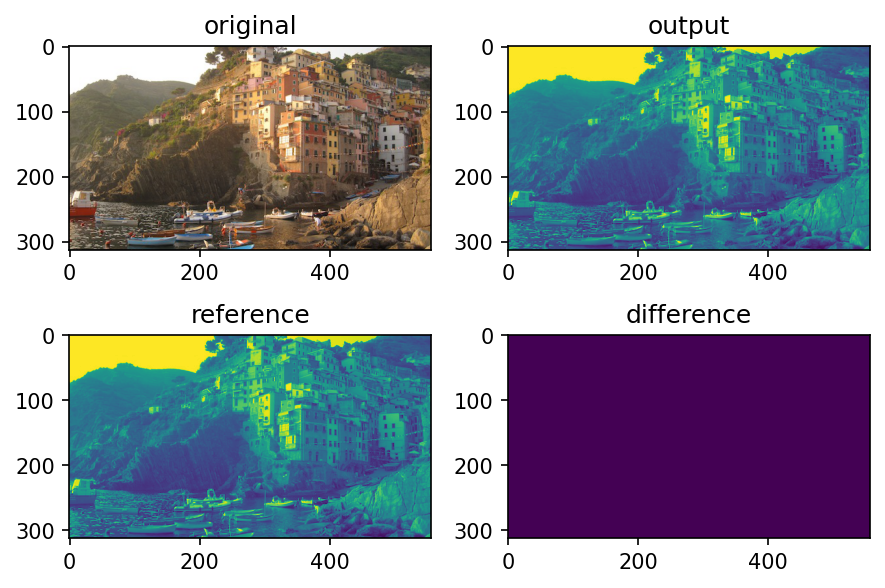

In [74]:
# plot output images
import matplotlib.pyplot as plt
_,ax = plt.subplots(2,2, dpi=150)

ax[0][0].imshow(plt.imread("../src/HW1/cinque_terre_small.jpg"))
ax[0][0].set_title("original")
ax[0][0].grid(False)

ax[0][1].imshow(plt.imread("HW1_output.png"))
ax[0][1].set_title("output")
ax[0][1].grid(False)

ax[1][0].imshow(plt.imread("HW1_reference.png"))
ax[1][0].set_title("reference")
ax[1][0].grid(False)

ax[1][1].imshow(plt.imread("HW1_differenceImage.png"))
ax[1][1].set_title("difference")
ax[1][1].grid(False)

plt.tight_layout()
plt.show()

## 🏁🏁 SELESAI 🏁🏁